In [16]:
Example

In [10]:
import requests
import pandas
import json

# Set up to get the newer Page Views data from Wikimedia
headers={'User-Agent' : 'https://github.com/ucalegon1979', 'From' : 'ucalegon@uw.edu'}
endpoint = 'https://wikimedia.org/api/rest_v1/metrics/{service}/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
start = '2015070100'
end = '2017100100'

dfpageviews = pandas.DataFrame()

# Loop over the list of access types to create separate files for each
for a in ['desktop', 'mobile-app', 'mobile-web']:
    
    params = {  'service' : 'pageviews',
                'project' : 'en.wikipedia.org',
                'access' : a,
                'agent' : 'user',
                'granularity' : 'daily',
                'start' : start,
                'startmonth' : '{:.6}'.format(start),
                'end' : end,
                'endmonth' : '{:.6}'.format(end)
                }
    
    # Create the api call and get the page views data
    api_call = requests.get(endpoint.format(**params))
    data = api_call.json()
    
    # Write the json data to a file
    filename = '{service}_{access}_{startmonth}-{endmonth}.json'.format(**params)
    with open(filename, 'w') as fp:
        json.dump(data, fp)
    
    # Present the page views data as a dataframe
    df = pandas.DataFrame.from_dict(data['items'])
    df[['timestamp','views']] = df[['timestamp','views']].apply(pandas.to_numeric)
    
    # union these with the other access types
    dfpageviews = pandas.concat([dfpageviews, df])
    
#end for loop


Convert the JSON files into Pandas dataframes and join them together on date

In [11]:
# Set up to get the newer Page Views data from Wikimedia
endpoint = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

params = {'project' : 'en.wikipedia.org',
            'access-site' : 'all-sites',
            'granularity' : 'daily',
            'start' : '2008010100',
            'end' : '2016080100'
            }

# Create the api call and get the page views data
api_call = requests.get(endpoint.format(**params))
data = api_call.json()


# Write the json data to a file
with open('pagecounts_all-access_200801-201607.json', 'w') as fp:
    json.dump(data, fp)
    
# Present the page views data as a dataframe
dfpagecount = pandas.DataFrame.from_dict(data['items'])

In [12]:
import numpy
#Transform the data 

# Create separate colums for the different access types
dfpageviews = dfpageviews.pivot(index='timestamp', columns='access', values='views',)

# Split out the year and month from the timestamp
dfpageviews.reset_index(inplace=True)
dfpageviews['year'] = dfpageviews['timestamp'].apply(lambda s: str(s)[:4])
dfpageviews['month'] = dfpageviews['timestamp'].apply(lambda s: str(s)[4:6])

# Combine the mobile counts
dfpageviews['mobile'] = dfpageviews['mobile-app'] + dfpageviews['mobile-web']

# Drop unneccessary columns
columns_to_drop = ['timestamp', 'mobile-app', 'mobile-web']
dfpageviews.drop(columns_to_drop, axis=1, inplace=True)

# Aggregate the dataframe up to year and month
df = dfpageviews.groupby(by=['year', 'month'])[['mobile','desktop']].sum()
df.reset_index(inplace=True)
df['all'] = df['mobile'] + df['desktop']
df.columns = ['year','month','pageview_mobile_views','pageview_desktop_views','pageview_all_views']

In [13]:
# Transform and merge the older, legacy pagecount data, joining on year and month
dfpagecount['year'] = dfpagecount['timestamp'].apply(lambda s: str(s)[:4])
dfpagecount['month'] = dfpagecount['timestamp'].apply(lambda s: str(s)[4:6])
df2 = dfpagecount.groupby(by=['year', 'month'])['count'].sum()
df2 = df2.reset_index()
df2.columns = ['year','month','pagecount_all_views']
dfall = pandas.merge(df, df2, on=['year','month'], how='outer')

In [14]:
dfall.sort_values(by=['year','month'], inplace=True)
dfall.fillna(value=0)
dfall.to_csv('en-wikipedia_traffic_200801-201709.csv')

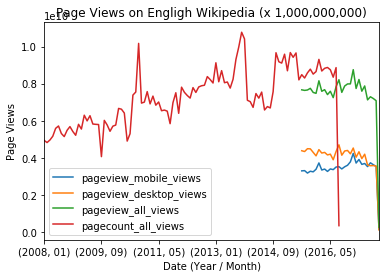

In [15]:
import matplotlib
%matplotlib inline

ax = dfall.plot.line(x=['year','month'],
                     y=['pageview_mobile_views','pageview_desktop_views','pageview_all_views','pagecount_all_views'],
                     title='Page Views on Engligh Wikipedia (x 1,000,000,000)')
ax.set(xlabel="Date (Year / Month)", ylabel="Page Views")